### ***Solar Flare Prediction Model***
We use SDO/HMI LOS magnetograms of ARs as the input
data of the proposed hybrid CNN model. 

SDO/HMI began its routine observation on 2010 April
30, and provided a continuous and high-quality photospheric
magnetic field observation. Near the end of 2012, the SDO/HMI
team started to release a new data product named Space-weather
HMI Active Region Patches (SHARP; Bobra et al. 2014), which
is convenient for AR event forecasting. These data are publicly
available at the Joint Science Operations Center, and the LOS
magnetograms of ARs can be obtained from SHARP (hmi.
sharp_cea_720s).

The data we are using is from 2022 to March 2023 and contains the Magnetogram images of about 18 Class C and 18 Class M Flares and has a total of 887 training images and 105 testing images. To ensure randomness of the data, the images are from random timestamp. 

In [1]:
#check the GPU version
!nvidia-smi

Fri May 12 08:55:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###**Data Insights**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!ls /content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images

dataset_images.zip  test  train


In [4]:

#walkthrough the datasets to get an idea of the data we are using 
import os
walkthrough = os.walk("/content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images")
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


There are 2 directories and 1 images in /content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images
There are 2 directories and 0 images in /content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images/train
There are 0 directories and 440 images in /content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images/train/C_Class_Flare
There are 0 directories and 444 images in /content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images/train/M_Class_Flare
There are 2 directories and 0 images in /content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images/test
There are 0 directories and 47 images in /content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images/test/C_CLass_Flare
There are 0 directories and 60 images in /content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images/test/M_Class_Flare


To ease the process of plotting the results, import the `helper_functions.py` file to avoid unnecessary repetitions of plotting functions 

In [5]:
#to ease the process of plotting the results, import the helper_functions.py file 
#Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-12 08:59:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-12 08:59:18 (78.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
#import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### **Data Visualisation**
In order to get an idea of the magnetogram image, let's first visualize it.

In [7]:
!ls /content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images/train/C_Class_Flare

 20220630_032400_hmi.sharp_cea_720s_609.jpg
 20220630_054800_hmi.sharp_cea_720s_609.jpg
 20220630_081200_hmi.sharp_cea_720s_609.jpg
 20220630_101200_hmi.sharp_cea_720s_609.jpg
 20220630_121200_hmi.sharp_cea_720s_609.jpg
 20220630_133600_hmi.sharp_cea_720s_609.jpg
 20220630_162400_hmi.sharp_cea_720s_609.jpg
 20220630_184800_hmi.sharp_cea_720s_609.jpg
 20220630_204800_hmi.sharp_cea_720s_609.jpg
 20220630_233600_hmi.sharp_cea_720s_609.jpg
 20220701_030000_hmi.sharp_cea_720s_609.jpg
 20220701_061200_hmi.sharp_cea_720s_609.jpg
 20220701_090000_hmi.sharp_cea_720s_609.jpg
 20220701_113600_hmi.sharp_cea_720s_609.jpg
 20220701_143600_hmi.sharp_cea_720s_609.jpg
 20220701_173600_hmi.sharp_cea_720s_609.jpg
 20220701_210000_hmi.sharp_cea_720s_609.jpg
 20220701_230000_hmi.sharp_cea_720s_609.jpg
 20220702_021200_hmi.sharp_cea_720s_609.jpg
 20220702_044800_hmi.sharp_cea_720s_609.jpg
 20220702_073600_hmi.sharp_cea_720s_609.jpg
 20220702_094800_hmi.sharp_cea_720s_609.jpg
 20220702_122400_hmi.sharp_cea_7

In [10]:
#to generat random images from C_Class_Flare image directory
import numpy as np
files = !ls /content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images/train/C_Class_Flare
filename = np.random.choice(files)
filename  = filename.strip() #strip() functions removes any blank spaces present in the filepath for smoothness.
filename
#files

'20230108_061200_hmi.sharp_cea_720s_1692.jpg'

Text(0.5, 1.0, 'C_Class_Flare Magnetogram Image')

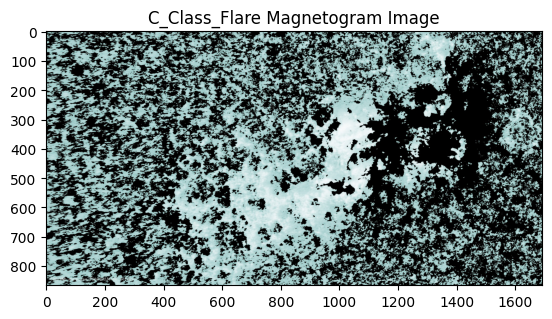

In [12]:
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image


image = Image.open('/content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images/train/C_Class_Flare' + '/' + filename)
image_array = np.array(image)

plt.imshow(image_array)
plt.title("C_Class_Flare Magnetogram Image")


A magnetogram is an image taken by an instrument (magnetograph) that shows the strength, polarity, and location of the magnetic fields on the Sun. The strength of a magnetic field is directly associated to it's ability to produce solar flares. Hence the Magnetogram images are a good reference to predict solar flares 

In [14]:
#Get the image tensor
print(image_array)

[[[142 203 198]
  [157 209 205]
  [163 208 205]
  ...
  [ 10   0   2]
  [  4   0   0]
  [  0   3   0]]

 [[152 194 192]
  [161 197 197]
  [170 202 201]
  ...
  [ 13   0   2]
  [  7   0   1]
  [  0   4   1]]

 [[163 193 193]
  [166 190 192]
  [177 195 197]
  ...
  [ 10   0   4]
  [  2   0   5]
  [  0   7   5]]

 ...

 [[  0   4   4]
  [ 11   0   2]
  [ 18   0   7]
  ...
  [  3   0   0]
  [  0   7   0]
  [  0   7   0]]

 [[  0   5   5]
  [  0   9   7]
  [144 191 185]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[175 191 191]
  [166 196 194]
  [156 203 197]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


In [13]:
#maximum value 
np.max(image_array)

255

In [15]:
#define training and testing directories for future use
train_dir = "/content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images/train"

test_dir = "/content/drive/MyDrive/exploratory_project/SD0_HMI_LOS_magnetogram_images/test"

In [18]:
import tensorflow as tf


train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode = 'binary',
                                                                 batch_size = 32,
                                                                 image_size = (225, 225),
                                                                 shuffle = True #shuffle allows random images to be passed to the network
                                                                 )



test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'binary',
                                                                image_size = (225, 225),
                                                                batch_size = 32,
                                                                shuffle = True)
#testing_data = tf.keras.utils.normalize(test_data)

Found 884 files belonging to 2 classes.
Found 107 files belonging to 2 classes.


In [19]:
#create checkpoint callback

checkpoint_path = "Solar_Flare_Prediction_model_checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = False,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True)

In [20]:
#create data augmentation layer into the model

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.Rescaling(1/255.) 
  
], name = 'data_augmentation')

In [21]:
#import the transfer learning model to be implemented
import tensorflow as tf
base_model = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    classes = 2
)   
base_model.layers

In [22]:
type(base_model.layers)

list

In [42]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model


normalization_layer = tf.keras.layers.experimental.preprocessing.Normalization()(base_model.layers[0].output)


#new_layer = BatchNormalization()(layer_2)
new_layer = base_model.layers[1](normalization_layer)
#layer_1 = Dense(64, activation = 'relu')(normalization_layer)
#layer_2 = Dense(64, activation = 'relu')(layer_1)
#new_layer = base_model.layers[1](new_layer)

for i in range(2, 18):
  new_layer = base_model.layers[i](new_layer)

baseline_model = Model(inputs = base_model.inputs, outputs = new_layer)
                   

baseline_model.layers


In [30]:
baseline_model = tf.keras.Model.save(baseline_model, 'baseline_model.h5')

In [31]:
test_data.element_spec[1].shape

TensorShape([None, 1])

In [44]:
baseline_model.layers[1:3]

In [45]:
#for layer in baseline_model.layers[1:3]:
  #layers.trainable = True
baseline_model.trainable = True

inputs = layers.Input(shape = (225, 225, 3),
                      name = 'input_layer')


#x = data_augmentation(normalization_layer)

x = baseline_model(inputs)
 

x = layers.GlobalAveragePooling2D()(x)
#tf.reduce_mean(x, axis = 3, keepdims = True)

outputs = layers.Dense(1, 
                       activation ='sigmoid')(x)

#outputs = tf.reduce_mean(outputs, axis = 0, keepdims = True)
#outputs = tf.squeeze(outputs, axis = 0)
#outputs = tf.reduce_mean(outputs, axis = 0, keepdims = True)
#outputs = tf.squeeze(outputs, axis = 0)

model_1 = Model(inputs, outputs)


model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(
    axis = 1
),
                optimizer = 'adam',
                metrics = ["accuracy"])

#history_1 = model_1.fit(train_data,
 #                       steps_per_epoch = len(train_data),
  #                      validation_data = test_data,
   #                     validation_steps = len(test_data),
    #                    )

In [46]:
outputs.shape

TensorShape([None, 1])

In [47]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 225, 225, 3)]     0         
                                                                 
 model_3 (Functional)        (None, None, None, 512)   14714695  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,208
Trainable params: 14,715,201
Non-trainable params: 7
_________________________________________________________________


In [49]:
history_1 = model_1.fit(train_data,
                       steps_per_epoch = len(train_data),
                       epochs = 10,
                       validation_data = test_data,
                       validation_steps = len(test_data),
                       callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                                    patience = 3),
                                    
                                    create_tensorboard_callback(checkpoint_path,
                                                                experiment_name = "VGG_16_model")]
                        )

Saving TensorBoard log files to: Solar_Flare_Prediction_model_checkpoint.ckpt/VGG_16_model/20230512-095128
Epoch 1/10
28/28 [==============================] - 190s 7s/step - loss: 72.7864 - accuracy: 0.4808 - val_loss: 0.6928 - val_accuracy: 0.5607
Epoch 2/10
28/28 [==============================] - 13s 313ms/step - loss: 0.7765 - accuracy: 0.4932 - val_loss: 0.6927 - val_accuracy: 0.5607
Epoch 3/10
28/28 [==============================] - 13s 352ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5607
Epoch 4/10
28/28 [==============================] - 13s 385ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6927 - val_accuracy: 0.5607


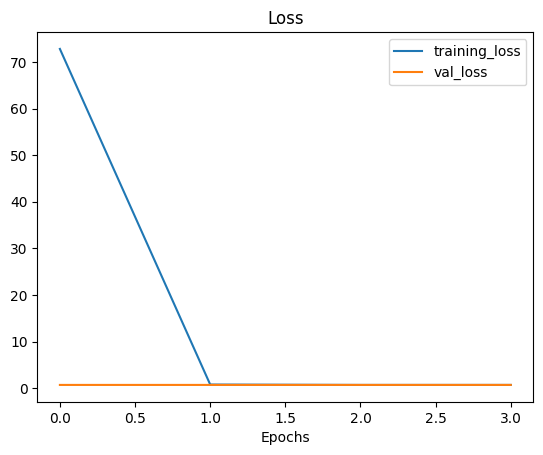

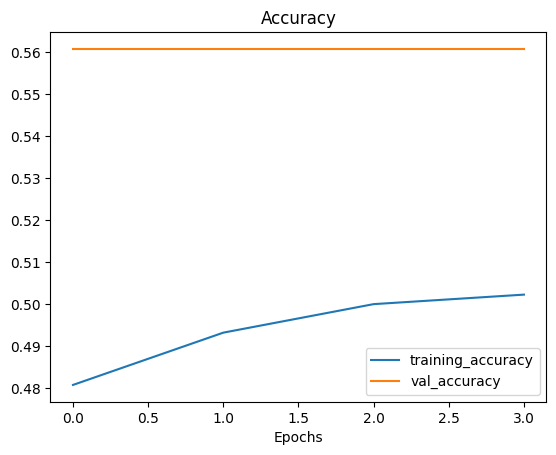

In [52]:
plot_loss_curves(history_1)

In [86]:
#for layer in baseline_model.layers[1:3]:
  #layer.trainable = True

IMAGE_SIZE = (225, 225, 3)
inputs = layers.Input(shape = IMAGE_SIZE,
                      name = 'input_layer',
                      )

x = data_augmentation(inputs)

x = baseline_model(x)
#x = tf.keras.layers.Conv2D(filters = 2,
                           #kernel_size = 3,
                           #strides = True,
                           #padding = "valid")(x)

#x = tf.keras.layers.Dense(64, activation = 'relu')(x)                           


x = layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)



#tf.reduce_mean(x, axis = 3, keepdims = True)

outputs = layers.Dense(1, 
                       activation ='sigmoid')(x)

#outputs = tf.reduce_mean(outputs, axis = 0, keepdims = True)
#outputs = tf.squeeze(outputs, axis = 0)
#outputs = tf.reduce_mean(outputs, axis = 0, keepdims = True)
#outputs = tf.squeeze(outputs, axis = 0)

model_2 = Model(inputs, outputs)


model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(
    axis = 1
),
                optimizer = 'adam',
                metrics = ["accuracy"])

#history_1 = model_1.fit(train_data,
 #                       steps_per_epoch = len(train_data),
  #                      validation_data = test_data,
   #                     validation_steps = len(test_data),
    #                    )

In [87]:
model_2.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 225, 225, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 model_14 (Functional)       (None, None, None, 512)   14680647  
                                                                 
 global_average_pooling2d_14  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 513

In [88]:
history_2 = model_2.fit(train_data,
                       steps_per_epoch = len(train_data),
                       epochs = 5,
                       validation_data = test_data,
                       validation_steps = len(test_data),)

Epoch 1/5
28/28 [==============================] - 39s 1s/step - loss: 0.6932 - accuracy: 0.4593 - val_loss: 0.6931 - val_accuracy: 0.4393
Epoch 2/5
28/28 [==============================] - 34s 1s/step - loss: 0.6932 - accuracy: 0.4638 - val_loss: 0.6932 - val_accuracy: 0.4393
Epoch 3/5
28/28 [==============================] - 26s 952ms/step - loss: 0.6932 - accuracy: 0.5068 - val_loss: 0.6930 - val_accuracy: 0.5607
Epoch 4/5
28/28 [==============================] - 24s 821ms/step - loss: 0.6932 - accuracy: 0.4796 - val_loss: 0.6931 - val_accuracy: 0.5607
Epoch 5/5
28/28 [==============================] - 29s 1s/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6930 - val_accuracy: 0.5607


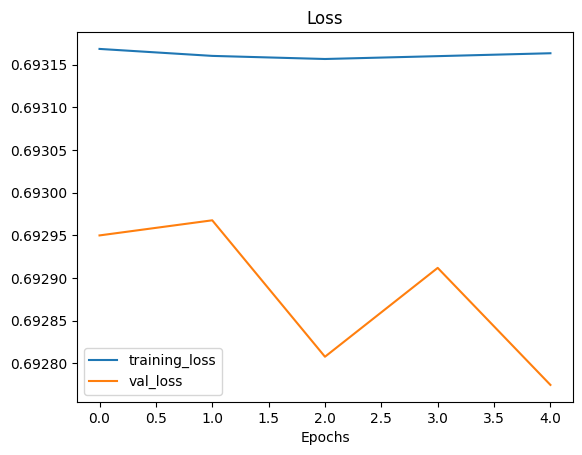

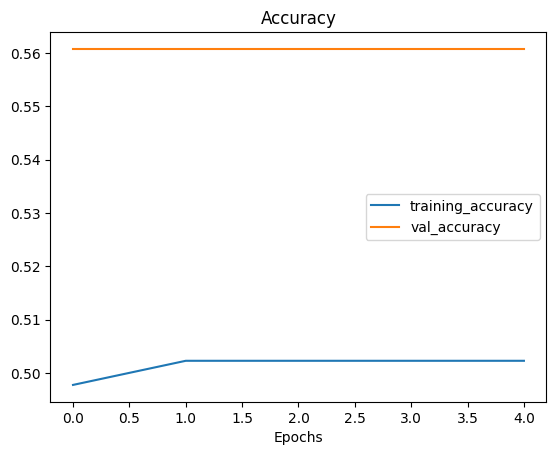

In [46]:
plot_loss_curves(history_2)

In [97]:
for layer in baseline_model.layers[1:3]:
  layer.trainable = True

IMAGE_SIZE = (225, 225, 3)
inputs = layers.Input(shape = IMAGE_SIZE,
                      name = 'input_layer',
                      )

#x = data_augmentation(inputs)

x = base_model(inputs)
#x = tf.keras.layers.Conv2D(filters = 2,
                           #kernel_size = 3,
                           #strides = True,
                           #padding = "valid")(x)

#x = tf.keras.layers.Dense(64, activation = 'relu')(x)                           


x = layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Flatten()(x)



#tf.reduce_mean(x, axis = 3, keepdims = True)

outputs = layers.Dense(1, 
                       activation ='sigmoid')(x)

#outputs = tf.reduce_mean(outputs, axis = 0, keepdims = True)
#outputs = tf.squeeze(outputs, axis = 0)
#outputs = tf.reduce_mean(outputs, axis = 0, keepdims = True)
#outputs = tf.squeeze(outputs, axis = 0)

model_3 = Model(inputs, outputs)


model_3.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = 'adam',
                metrics = ["accuracy"])

#history_1 = model_1.fit(train_data,
 #                       steps_per_epoch = len(train_data),
  #                      validation_data = test_data,
   #                     validation_steps = len(test_data),
    #                    )

In [98]:
model_3.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 225, 225, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_17  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_36 (Dense)            (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [99]:
history_3 = model_3.fit(train_data,
                        steps_per_epoch = len(train_data),
                        epochs = 5,
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
28/28 [==============================] - 8s 86ms/step - loss: 0.8607 - accuracy: 0.5102 - val_loss: 0.7020 - val_accuracy: 0.5607
Epoch 2/5
28/28 [==============================] - 3s 80ms/step - loss: 0.7053 - accuracy: 0.4955 - val_loss: 0.6925 - val_accuracy: 0.5607
Epoch 3/5
28/28 [==============================] - 3s 80ms/step - loss: 0.7007 - accuracy: 0.5068 - val_loss: 0.7012 - val_accuracy: 0.4393
Epoch 4/5
28/28 [==============================] - 3s 79ms/step - loss: 0.6960 - accuracy: 0.5147 - val_loss: 0.6939 - val_accuracy: 0.4393
Epoch 5/5
28/28 [==============================] - 3s 80ms/step - loss: 7.2329 - accuracy: 0.4830 - val_loss: 0.6930 - val_accuracy: 0.5607


In [50]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False,
                                                  classes = 2)
base_model.trainable = False  

IMAGE_SIZE = (225, 225, 3)
inputs = layers.Input(shape = IMAGE_SIZE,
                      name = 'input_layer',
                      )

x = data_augmentation(inputs)

x = base_model(inputs)
#x = tf.keras.layers.Conv2D(filters = 2,
                           #kernel_size = 3,
                           #strides = True,
                           #padding = "valid")(x)

x = tf.keras.layers.Dense(64, activation = 'relu')(x)                           


x = layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Flatten()(x)



#tf.reduce_mean(x, axis = 3, keepdims = True)

outputs = layers.Dense(1, 
                       activation ='sigmoid')(x)

#outputs = tf.reduce_mean(outputs, axis = 0, keepdims = True)
#outputs = tf.squeeze(outputs, axis = 0)
#outputs = tf.reduce_mean(outputs, axis = 0, keepdims = True)
#outputs = tf.squeeze(outputs, axis = 0)

model_4 = Model(inputs, outputs)


model_4.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = 'adam',
                metrics = ["accuracy"])

#history_1 = model_1.fit(train_data,
 #                       steps_per_epoch = len(train_data),
  #                      validation_data = test_data,
   #                     validation_steps = len(test_data),
    #                    )

16705208/16705208 [==============================] - 1s 0us/step


In [51]:
model_4.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 225, 225, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 dense_9 (Dense)             (None, 7, 7, 64)          81984     
                                                                 
 global_average_pooling2d_1   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,131,620
Trainable params: 82,049
Non-trainable params: 4,049,571
____________________________________________

In [54]:
history_4 = model_4.fit(train_data,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        epochs = 10,
                        callbacks =[#tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                                  #  patience = 3),
                                    
                                    create_tensorboard_callback(checkpoint_path,
                                                                experiment_name = "EfficientNetB0_model")])

Saving TensorBoard log files to: Solar_Flare_Prediction_model_checkpoint.ckpt/EfficientNetB0_model/20230512-100200
Epoch 1/10
28/28 [==============================] - 12s 324ms/step - loss: 0.2437 - accuracy: 0.9219 - val_loss: 0.5325 - val_accuracy: 0.7850
Epoch 2/10
28/28 [==============================] - 11s 256ms/step - loss: 0.2137 - accuracy: 0.9367 - val_loss: 0.4772 - val_accuracy: 0.7664
Epoch 3/10
28/28 [==============================] - 12s 333ms/step - loss: 0.1905 - accuracy: 0.9468 - val_loss: 0.5149 - val_accuracy: 0.7757
Epoch 4/10
28/28 [==============================] - 10s 276ms/step - loss: 0.1773 - accuracy: 0.9468 - val_loss: 0.4933 - val_accuracy: 0.7850
Epoch 5/10
28/28 [==============================] - 11s 264ms/step - loss: 0.1606 - accuracy: 0.9468 - val_loss: 0.5265 - val_accuracy: 0.7944
Epoch 6/10
28/28 [==============================] - 12s 307ms/step - loss: 0.1384 - accuracy: 0.9661 - val_loss: 0.5840 - val_accuracy: 0.7757
Epoch 7/10
28/28 [=========

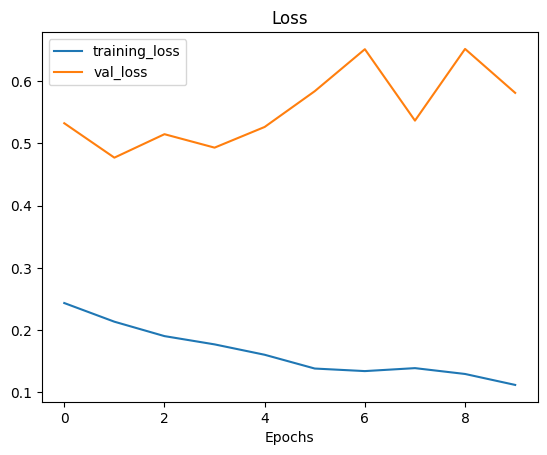

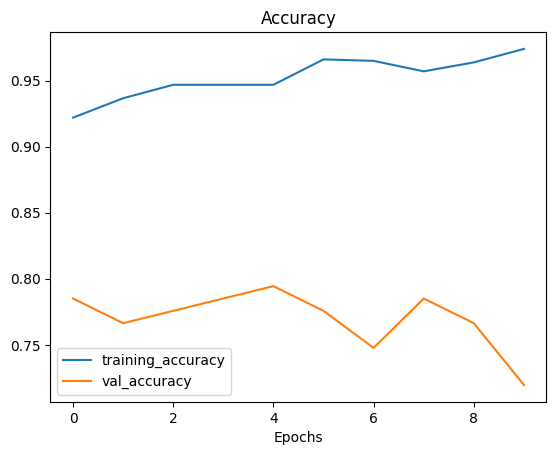

In [55]:
plot_loss_curves(history_4)

###viewing our results in tensorboard


In [58]:
#upload tensorboard dev records
!tensorboard dev upload --logdir ./Solar_Flare_Prediction_model_checkpoint.ckpt \
--name "Solar Flare Prediction Model"\
--description "A comparison of two transfer learning models on solar magnetogram images"\
--one_shot #exits the uploader once its finished uploading

2023-05-12 10:22:35.185247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./Solar_Flare_Prediction_model_checkpoint.ckpt

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   YRBT-RPCS



New experiment created. View your TensorBoard at: